# Biboliotecas utilizadas

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import math
import time
from collections import deque
import mediapipe as mp

# Entrenamiento del modelo para la detección de emociones usando fine tuning

Usando: cuda
Train: 28709 | Val: 3589


c:\Users\Javier\anaconda3\envs\VC_P5_emotions\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 01/50 | Train Acc: 0.484 | Val Acc: 0.592
✓ Modelo guardado (Val Acc: 0.592)
Epoch 02/50 | Train Acc: 0.586 | Val Acc: 0.624
✓ Modelo guardado (Val Acc: 0.624)
Epoch 03/50 | Train Acc: 0.612 | Val Acc: 0.633
✓ Modelo guardado (Val Acc: 0.633)
Epoch 04/50 | Train Acc: 0.627 | Val Acc: 0.639
✓ Modelo guardado (Val Acc: 0.639)
Epoch 05/50 | Train Acc: 0.645 | Val Acc: 0.664
✓ Modelo guardado (Val Acc: 0.664)
Epoch 06/50 | Train Acc: 0.661 | Val Acc: 0.659
Epoch 07/50 | Train Acc: 0.669 | Val Acc: 0.667
✓ Modelo guardado (Val Acc: 0.667)
Epoch 08/50 | Train Acc: 0.683 | Val Acc: 0.670
✓ Modelo guardado (Val Acc: 0.670)
Epoch 09/50 | Train Acc: 0.693 | Val Acc: 0.668
Epoch 10/50 | Train Acc: 0.706 | Val Acc: 0.676
✓ Modelo guardado (Val Acc: 0.676)
Epoch 11/50 | Train Acc: 0.711 | Val Acc: 0.673
Epoch 12/50 | Train Acc: 0.725 | Val Acc: 0.678
✓ Modelo guardado (Val Acc: 0.678)
Epoch 13/50 | Train Acc: 0.735 | Val Acc: 0.679
Epoch 14/50 | Train Acc: 0.740 | Val Acc: 0.686
✓ Modelo guar

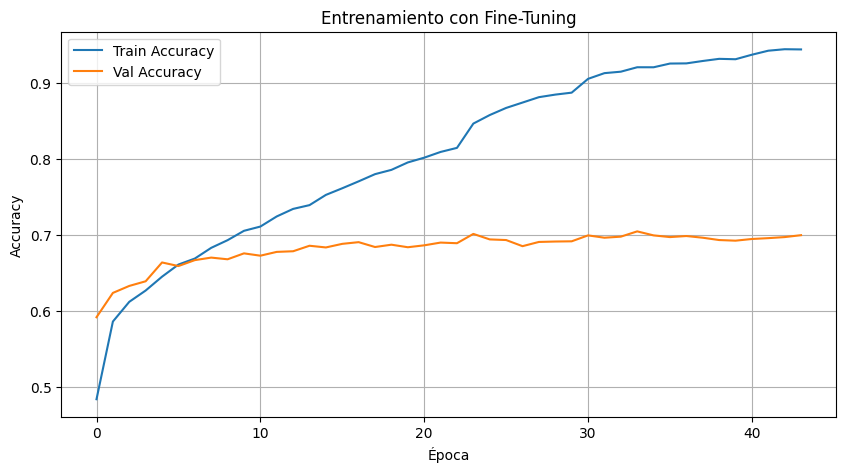


✓ Mejor Val Accuracy: 0.705
✓ Modelo guardado en: best_resnet18_finetuned.pth


In [ ]:
# ========== CONFIGURACIÓN ==========
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando: {device}')

BATCH_SIZE = 32  # Reduce si tienes poca GPU RAM
EPOCHS = 50
LEARNING_RATE = 1e-4  # LR bajo para fine-tuning
WEIGHT_DECAY = 1e-4
PATIENCE = 10

EMOTIONS = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

# ========== DATASET ==========
class FER2013RGB(Dataset):
    def __init__(self, csv_path, usage="Training", transform=None):
        self.data = pd.read_csv(csv_path)
        self.data = self.data[self.data['Usage'] == usage].reset_index(drop=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        pixels = np.array(list(map(int, self.data.loc[idx, 'pixels'].split())))
        pixels = pixels.reshape(48, 48).astype(np.uint8)
        pixels = np.stack([pixels]*3, axis=-1)  # Convertir a RGB
        label = int(self.data.loc[idx, 'emotion'])
        
        if self.transform:
            pixels = self.transform(pixels)
        
        return pixels, label

# ========== DATA AUGMENTATION FUERTE ==========
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ========== CARGAR DATOS ==========
train_dataset = FER2013RGB('fer2013.csv', usage='Training', transform=train_transform)
val_dataset = FER2013RGB('fer2013.csv', usage='PublicTest', transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f'Train: {len(train_dataset)} | Val: {len(val_dataset)}')

# ========== MODELO CON FINE-TUNING ==========
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# DESCONGELAR TODAS LAS CAPAS (fine-tuning completo)
for param in model.parameters():
    param.requires_grad = True

# Reemplazar última capa
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 7)
)

model = model.to(device)

# ========== OPTIMIZACIÓN ==========
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)

# ========== EARLY STOPPING ==========
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_acc = 0
        self.early_stop = False
    
    def __call__(self, val_acc):
        if val_acc > self.best_acc + self.min_delta:
            self.best_acc = val_acc
            self.counter = 0
            return True  # Mejoró
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
            return False

early_stopping = EarlyStopping(patience=PATIENCE)

# ========== ENTRENAMIENTO ==========
train_accs, val_accs = [], []
best_val_acc = 0

for epoch in range(1, EPOCHS + 1):
    # TRAIN
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)
    
    train_acc = train_correct / train_total
    train_accs.append(train_acc)
    
    # VALIDATION
    model.eval()
    val_correct, val_total = 0, 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    
    val_acc = val_correct / val_total
    val_accs.append(val_acc)
    
    # Scheduler
    scheduler.step(val_acc)
    
    print(f'Epoch {epoch:02d}/{EPOCHS} | Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f}')
    
    # Guardar mejor modelo
    if early_stopping(val_acc):
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_resnet18_finetuned.pth')
        print(f'✓ Modelo guardado (Val Acc: {val_acc:.3f})')
    
    if early_stopping.early_stop:
        print(f'Early stopping activado en época {epoch}')
        break

# ========== VISUALIZACIÓN ==========
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.title('Entrenamiento con Fine-Tuning')
plt.legend()
plt.grid(True)
plt.show()

print(f'\n✓ Mejor Val Accuracy: {best_val_acc:.3f}')
print(f'✓ Modelo guardado en: best_resnet18_finetuned.pth')

# Probar EMOCIONES

# Filtro según la emoción en real time

In [ ]:
# ========== CONFIGURACIÓN ==========
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando: {device}')

EMOTIONS = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

# ========== CARGAR MODELO ==========
model = models.resnet18(weights=None)
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.5),
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.4),
    torch.nn.Linear(256, 7)
)

model.load_state_dict(torch.load('best_resnet18_finetuned.pth', map_location=device))
model.eval()
model.to(device)

print("✓ Modelo cargado correctamente")

# ========== TRANSFORMS ==========
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ========== DETECTOR DE CARAS ==========
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')


# ========== EFECTOS CREATIVOS POR EMOCIÓN ==========

def draw_happy_effect(frame, x, y, w, h):
    """Happy: Corazones flotando y arcoíris"""
    center_x = x + w//2
    
    # Arcoíris encima de la cabeza
    colors = [(0, 0, 255), (0, 127, 255), (0, 255, 255), (0, 255, 0), (255, 255, 0)]
    for i, color in enumerate(colors):
        arc_y = y - 100 + i * 8
        cv2.ellipse(frame, (center_x, arc_y), (w//2 + i*5, 40), 
                   0, 0, 180, color, 6)
    
    # Corazones flotando
    for i in range(3):
        heart_x = center_x + (i-1) * 60
        heart_y = y - 150 - i * 20
        # Dibujar corazón
        cv2.circle(frame, (heart_x - 10, heart_y), 15, (255, 105, 180), -1)
        cv2.circle(frame, (heart_x + 10, heart_y), 15, (255, 105, 180), -1)
        pts = np.array([[heart_x - 25, heart_y], [heart_x, heart_y + 25], 
                       [heart_x + 25, heart_y]], np.int32)
        cv2.fillPoly(frame, [pts], (255, 105, 180))


def draw_sad_effect(frame, x, y, w, h):
    """Sad: Pañuelo secando lágrimas y lluvia"""
    # Pañuelo cerca de la cara
    tissue_x = x - 50
    tissue_y = y + h//2
    
    # Dibujar pañuelo (rectángulo ondulado)
    cv2.rectangle(frame, (tissue_x, tissue_y), 
                 (tissue_x + 40, tissue_y + 50), (240, 240, 255), -1)
    cv2.rectangle(frame, (tissue_x, tissue_y), 
                 (tissue_x + 40, tissue_y + 50), (200, 200, 220), 3)
    # Detalles del pañuelo
    for i in range(5):
        cv2.line(frame, (tissue_x + i*8, tissue_y), 
                (tissue_x + i*8, tissue_y + 50), (220, 220, 240), 1)
    
    # Lágrimas grandes cayendo
    tear_positions = [(x + w//4, y + h//2 + 10), (x + 3*w//4, y + h//2 + 10)]
    for tx, ty in tear_positions:
        for i in range(4):
            drop_y = ty + i * 25
            drop_size = 8 - i
            cv2.circle(frame, (tx, drop_y), drop_size, (255, 200, 150), -1)
            cv2.circle(frame, (tx, drop_y), drop_size + 2, (200, 150, 100), 2)
    
    # Nube de lluvia encima
    cloud_x, cloud_y = x + w//2, y - 80
    cv2.ellipse(frame, (cloud_x, cloud_y), (60, 30), 0, 0, 360, (150, 150, 150), -1)
    cv2.ellipse(frame, (cloud_x - 30, cloud_y + 10), (40, 25), 0, 0, 360, (130, 130, 130), -1)
    cv2.ellipse(frame, (cloud_x + 30, cloud_y + 10), (40, 25), 0, 0, 360, (130, 130, 130), -1)


def draw_angry_effect(frame, x, y, w, h):
    """Angry: Cuernos de demonio y llamas rodeando"""
    center_x, center_y = x + w//2, y + h//2
    
    # Cuernos rojos en la cabeza
    # Cuerno izquierdo
    horn_left = np.array([
        [x + w//4 - 10, y],
        [x + w//4 - 30, y - 50],
        [x + w//4, y - 10]
    ], np.int32)
    cv2.fillPoly(frame, [horn_left], (0, 0, 180))
    cv2.polylines(frame, [horn_left], True, (0, 0, 255), 3)
    
    # Cuerno derecho
    horn_right = np.array([
        [x + 3*w//4 + 10, y],
        [x + 3*w//4 + 30, y - 50],
        [x + 3*w//4, y - 10]
    ], np.int32)
    cv2.fillPoly(frame, [horn_right], (0, 0, 180))
    cv2.polylines(frame, [horn_right], True, (0, 0, 255), 3)
    
    # Anillo de fuego alrededor
    num_flames = 16
    for i in range(num_flames):
        angle = (360 / num_flames) * i
        rad = np.radians(angle)
        distance = max(w, h) // 2 + 40
        
        fx = int(center_x + distance * np.cos(rad))
        fy = int(center_y + distance * np.sin(rad))
        
        # Llama
        flame_size = 20 + np.random.randint(-5, 10)
        flame = np.array([
            [fx, fy - flame_size],
            [fx - 8, fy + 5],
            [fx + 8, fy + 5]
        ], np.int32)
        
        color = (0, np.random.randint(100, 200), np.random.randint(200, 255))
        cv2.fillPoly(frame, [flame], color)


def draw_surprise_effect(frame, x, y, w, h):
    """Surprise: Explosión de estrellas y signos de exclamación"""
    center_x, center_y = x + w//2, y + h//2
    
    # Signos de exclamación grandes
    exclamation_positions = [
        (x - 40, y + h//2),
        (x + w + 40, y + h//2),
        (center_x, y - 100)
    ]
    
    for ex, ey in exclamation_positions:
        # Parte superior del signo
        cv2.rectangle(frame, (ex - 8, ey - 50), (ex + 8, ey - 10), (0, 255, 255), -1)
        # Punto inferior
        cv2.circle(frame, (ex, ey), 10, (0, 255, 255), -1)
        # Borde
        cv2.rectangle(frame, (ex - 8, ey - 50), (ex + 8, ey - 10), (0, 200, 200), 3)
        cv2.circle(frame, (ex, ey), 10, (0, 200, 200), 3)
    
    # Estrellas brillantes explosionando
    for i in range(12):
        angle = (360 / 12) * i
        rad = np.radians(angle)
        distance = 100 + np.random.randint(-20, 20)
        
        sx = int(center_x + distance * np.cos(rad))
        sy = int(center_y + distance * np.sin(rad))
        
        cv2.drawMarker(frame, (sx, sy), (255, 255, 0), 
                      cv2.MARKER_STAR, 20, 3)


def draw_fear_effect(frame, x, y, w, h):
    """Fear: Fantasmas flotando y sombras oscuras"""
    # Sombra oscura alrededor
    overlay = frame.copy()
    cv2.rectangle(overlay, (0, 0), (frame.shape[1], frame.shape[0]), (0, 0, 0), -1)
    cv2.addWeighted(overlay, 0.4, frame, 0.6, 0, frame)
    
    # Fantasmas a los lados
    ghost_positions = [(x - 80, y + h//2), (x + w + 80, y + h//2)]
    
    for gx, gy in ghost_positions:
        # Cuerpo del fantasma
        cv2.ellipse(frame, (gx, gy - 30), (35, 45), 0, 0, 180, (200, 200, 255), -1)
        cv2.rectangle(frame, (gx - 35, gy - 30), (gx + 35, gy + 20), (200, 200, 255), -1)
        
        # Base ondulada
        for i in range(5):
            wave_x = gx - 35 + i * 15
            cv2.circle(frame, (wave_x, gy + 20), 8, (200, 200, 255), -1)
        
        # Ojos
        cv2.circle(frame, (gx - 12, gy - 35), 8, (0, 0, 0), -1)
        cv2.circle(frame, (gx + 12, gy - 35), 8, (0, 0, 0), -1)
        
        # Boca "O"
        cv2.circle(frame, (gx, gy - 15), 10, (0, 0, 0), -1)
        
        # Brillo fantasmal
        cv2.circle(frame, (gx - 12, gy - 35), 3, (255, 255, 255), -1)
        cv2.circle(frame, (gx + 12, gy - 35), 3, (255, 255, 255), -1)


def draw_disgust_effect(frame, x, y, w, h):
    """Disgust: Moscas volando y olor verde apestoso"""
    center_x, center_y = x + w//2, y + h//2
    
    # Líneas de olor verde subiendo
    for i in range(5):
        smell_x = center_x + (i - 2) * 25
        smell_y = y - 50
        
        # Línea ondulada del olor
        points = []
        for j in range(6):
            wave_offset = 10 * math.sin(j * 0.8)
            points.append([int(smell_x + wave_offset), smell_y - j * 20])
        
        pts = np.array(points, np.int32)
        cv2.polylines(frame, [pts], False, (0, 255, 100), 4)
    
    # Nube de olor verde
    cv2.ellipse(frame, (center_x, y - 120), (50, 30), 0, 0, 360, (0, 200, 50), -1)
    cv2.ellipse(frame, (center_x - 25, y - 100), (35, 25), 0, 0, 360, (0, 180, 40), -1)
    cv2.ellipse(frame, (center_x + 25, y - 100), (35, 25), 0, 0, 360, (0, 180, 40), -1)
    
    # Moscas volando
    import time
    for i in range(4):
        offset_x = 40 * math.sin(time.time() * 3 + i)
        offset_y = 30 * math.cos(time.time() * 4 + i)
        
        fly_x = int(center_x + offset_x + (i - 2) * 30)
        fly_y = int(center_y + offset_y - 50)
        
        # Cuerpo de la mosca
        cv2.circle(frame, (fly_x, fly_y), 5, (0, 0, 0), -1)
        # Alas
        cv2.ellipse(frame, (fly_x - 4, fly_y - 3), (8, 4), 45, 0, 360, (150, 150, 150), 1)
        cv2.ellipse(frame, (fly_x + 4, fly_y - 3), (8, 4), -45, 0, 360, (150, 150, 150), 1)


def draw_neutral_effect(frame, x, y, w, h):
    """Neutral: Aura zen con símbolo de meditación"""
    center_x, center_y = x + w//2, y + h//2
    
    # Círculos concéntricos zen
    for i in range(4):
        radius = 70 + i * 25
        alpha = 1 - (i / 4)
        thickness = max(1, int(3 * alpha))
        cv2.circle(frame, (center_x, center_y), radius, (200, 180, 150), thickness)
    
    # Símbolo OM encima
    om_x, om_y = center_x, y - 80
    
    # Dibujar "OM" estilizado
    cv2.putText(frame, "OM", (om_x - 30, om_y),
               cv2.FONT_HERSHEY_SIMPLEX, 1.5, (180, 160, 140), 3)
    
    # Pequeñas hojas cayendo suavemente
    for i in range(3):
        leaf_x = center_x + (i - 1) * 50
        leaf_y = y - 120 + i * 15
        
        # Hoja simple
        leaf = np.array([
            [leaf_x, leaf_y - 10],
            [leaf_x - 8, leaf_y + 5],
            [leaf_x, leaf_y],
            [leaf_x + 8, leaf_y + 5]
        ], np.int32)
        cv2.fillPoly(frame, [leaf], (100, 180, 100))
        cv2.polylines(frame, [leaf], True, (80, 150, 80), 2)


# Diccionario de funciones
EFFECT_FUNCTIONS = {
    "Happy": draw_happy_effect,
    "Sad": draw_sad_effect,
    "Angry": draw_angry_effect,
    "Surprise": draw_surprise_effect,
    "Fear": draw_fear_effect,
    "Disgust": draw_disgust_effect,
    "Neutral": draw_neutral_effect
}


# ========== CAPTURA DE WEBCAM ==========
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: No se pudo abrir la cámara")
    exit()

print("\n" + "="*60)
print("🎭 DETECTOR DE EMOCIONES - EFECTOS CREATIVOS 🎭")
print("="*60)
print("Controles: 'q' salir | 's' captura")
print("="*60 + "\n")

frame_count = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    frame = cv2.flip(frame, 1)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    faces = face_cascade.detectMultiScale(
        gray, scaleFactor=1.1, minNeighbors=5, minSize=(100, 100)
    )
    
    if len(faces) > 0:
        (x, y, w, h) = faces[0]
        
        face_img = frame[y:y+h, x:x+w]
        face_rgb = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
        face_pil = Image.fromarray(face_rgb)
        face_tensor = preprocess(face_pil).unsqueeze(0).to(device)
        
        with torch.no_grad():
            outputs = model(face_tensor)
            probas = torch.softmax(outputs, dim=1)
            pred_idx = probas.argmax(dim=1).item()
            confidence = probas[0, pred_idx].item()
        
        emotion = EMOTIONS[pred_idx]
        
        # ========== APLICAR EFECTO CREATIVO ==========
        effect_func = EFFECT_FUNCTIONS.get(emotion)
        if effect_func:
            effect_func(frame, x, y, w, h)
        
        # Texto discreto en la esquina
        cv2.putText(frame, f"{emotion} ({confidence:.0%})", 
                   (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
    
    cv2.imshow('🎭 Emotion Detector', frame)
    
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break
    elif key == ord('s'):
        cv2.imwrite(f'captura_{frame_count}.jpg', frame)
        print(f"✓ Captura guardada")
        frame_count += 1

cap.release()
cv2.destroyAllWindows()
print("✓ Finalizado")


Usando: cuda


C:\Users\asmae\AppData\Local\Temp\ipykernel_33340\386148875.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_resnet18_finetuned.pt

✓ Modelo cargado correctamente

🎭 DETECTOR DE EMOCIONES - EFECTOS CREATIVOS 🎭
Controles: 'q' salir | 's' captura

✓ Finalizado


# Libre

## Clase de métricas

In [ ]:
class AttentionMetrics:
    def __init__(self):
        self.blinks = 0
        self.total_time = 0
        self.last_blink_time = 0
        self.attention_history = deque(maxlen=100)
        self.start_time = time.time()
    
    def update_attention(self, is_attentive):
        self.attention_history.append(1 if is_attentive else 0)
        self.total_time = time.time() - self.start_time
    
    def get_attention_percentage(self):
        if len(self.attention_history) == 0:
            return 100
        return int(sum(self.attention_history) / len(self.attention_history) * 100)
    
    def get_blinks_per_minute(self):
        if self.total_time < 1:
            return 0
        return int(self.blinks / (self.total_time / 60))

## Función para calcular aspect ratio de ojos

In [ ]:
def calculate_eye_aspect_ratio(landmarks, eye_indices):
    A = np.linalg.norm(landmarks[eye_indices[1]] - landmarks[eye_indices[5]])
    B = np.linalg.norm(landmarks[eye_indices[2]] - landmarks[eye_indices[4]])
    C = np.linalg.norm(landmarks[eye_indices[0]] - landmarks[eye_indices[3]])
    ear = (A + B) / (2.0 * C)
    return ear

## Función para determinar si se está mirando a cámara

In [ ]:
def is_looking_at_camera(landmarks):
    nose_tip = landmarks[1]
    left_eye = landmarks[33]
    right_eye = landmarks[263]
    eye_center = (left_eye + right_eye) / 2
    horizontal_deviation = abs(nose_tip[0] - eye_center[0])
    return horizontal_deviation < 0.03

## Función para dibujar el dashboard

In [ ]:
def draw_dashboard(frame, attention_percent, is_attentive, metrics):
    h, w = frame.shape[:2]
    
    overlay = frame.copy()
    cv2.rectangle(overlay, (0, 0), (w, 150), (0, 0, 0), -1)
    cv2.addWeighted(overlay, 0.6, frame, 0.4, 0, frame)
    
    cv2.putText(frame, "ATTENTION AND CONCENTRATION METER",
               (w//2 - 350, 35), cv2.FONT_HERSHEY_DUPLEX, 1.0, (0, 255, 255), 2)
    
    status_text = "FOCUSED" if is_attentive else "DISTRACTED"
    status_color = (0, 255, 0) if is_attentive else (0, 0, 255)
    cv2.putText(frame, f"Status: {status_text}",
               (20, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.8, status_color, 2)
    
    cv2.putText(frame, f"Attention: {attention_percent}%",
               (20, 115), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
    
    bar_width = int(300 * (attention_percent / 100))
    cv2.rectangle(frame, (300, 90), (600, 125), (100, 100, 100), -1)
    cv2.rectangle(frame, (300, 90), (300 + bar_width, 125), status_color, -1)
    cv2.rectangle(frame, (300, 90), (600, 125), (255, 255, 255), 2)
    
    bpm = metrics.get_blinks_per_minute()
    cv2.putText(frame, f"Blinks/min: {bpm}",
               (650, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    
    minutes = int(metrics.total_time // 60)
    seconds = int(metrics.total_time % 60)
    cv2.putText(frame, f"Time: {minutes:02d}:{seconds:02d}",
               (w - 200, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    
    cv2.rectangle(overlay, (w - 250, 150), (w, h), (0, 0, 0), -1)
    cv2.addWeighted(overlay, 0.6, frame, 0.4, 0, frame)
    
    y_offset = 200
    
    looking = is_attentive and is_looking_at_camera
    look_color = (0, 255, 0) if looking else (0, 0, 255)
    cv2.circle(frame, (w - 220, y_offset), 15, look_color, -1)
    cv2.putText(frame, "Looking", (w - 190, y_offset + 5),
               cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
    
    y_offset += 60
    
    blink_color = (255, 255, 0)
    cv2.circle(frame, (w - 220, y_offset), 15, blink_color, -1)
    cv2.putText(frame, f"Blinks: {metrics.blinks}", (w - 190, y_offset + 5),
               cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
    
    y_offset = h - 150
    cv2.putText(frame, "TIPS:", (w - 230, y_offset),
               cv2.FONT_HERSHEY_DUPLEX, 0.6, (0, 255, 255), 1)
    
    y_offset += 30
    if bpm > 30:
        cv2.putText(frame, "Rest your eyes", (w - 230, y_offset),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 200, 100), 1)


## Ejecución del segundo prototipo

In [ ]:
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

BLINK_THRESHOLD = 0.2
BLINK_COOLDOWN = 0.3

metrics = AttentionMetrics()

LEFT_EYE = [33, 160, 158, 133, 153, 144]
RIGHT_EYE = [362, 385, 387, 263, 373, 380]

cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not open camera")
    exit()

print("\n" + "="*60)
print("ATTENTION AND CONCENTRATION METER")
print("="*60)
print("Controls: 'ESC' exit | 'r' reset metrics")
print("="*60 + "\n")

is_blinking = False

with mp_face_mesh.FaceMesh(
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as face_mesh:
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        frame = cv2.flip(frame, 1)
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        results = face_mesh.process(rgb_frame)
        
        is_attentive = False
        current_time = time.time()
        
        if results.multi_face_landmarks:
            face_landmarks = results.multi_face_landmarks[0]
            
            h, w, _ = frame.shape
            landmarks = np.array([(lm.x, lm.y, lm.z) for lm in face_landmarks.landmark])
            
            left_ear = calculate_eye_aspect_ratio(landmarks, LEFT_EYE)
            right_ear = calculate_eye_aspect_ratio(landmarks, RIGHT_EYE)
            avg_ear = (left_ear + right_ear) / 2.0
            
            if avg_ear < BLINK_THRESHOLD:
                if not is_blinking and (current_time - metrics.last_blink_time) > BLINK_COOLDOWN:
                    metrics.blinks += 1
                    metrics.last_blink_time = current_time
                    is_blinking = True
            else:
                is_blinking = False
            
            looking_at_camera = is_looking_at_camera(landmarks)
            
            if looking_at_camera:
                is_attentive = True
        
        metrics.update_attention(is_attentive)
        attention_percent = metrics.get_attention_percentage()
        
        draw_dashboard(frame, attention_percent, is_attentive, metrics)
        
        cv2.putText(frame, "Press 'ESC' to exit | 'R' to reset",
                   (10, frame.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        
        cv2.imshow('Attention Meter', frame)
        
        key = cv2.waitKey(1) & 0xFF
        if key == 27:
            break
        elif key == ord('r'):
            metrics = AttentionMetrics()
            print("Metrics reset")

cap.release()
cv2.destroyAllWindows()
print("\nSession finished")
print(f"Summary:")
print(f"  - Average attention: {metrics.get_attention_percentage()}%")
print(f"  - Total blinks: {metrics.blinks}")
print(f"  - Blinks/minute: {metrics.get_blinks_per_minute()}")


👁️ MEDIDOR DE ATENCIÓN Y CONCENTRACIÓN 👁️
Controles: 'q' salir | 'r' reiniciar métricas


✓ Sesión finalizada
Resumen:
  - Atención promedio: 82%
  - Total parpadeos: 5
  - Parpadeos/minuto: 9
  - Bostezos: 17
  - Distracciones: 0
